In [3]:
pip install emoji

     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=8679d75b7a88c12bbdf76c90378faa90539e39292ee7c66d384aca224a28565d
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


In [4]:
import os 
import re
import emoji
import plotly.express as px
import regex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
import datetime
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [5]:
def startsWithDateAndTime(s):
    pattern = '^\d{1,2}\/\d{1,2}\/\d{2} \d{1,2}\:\d{1,2} - '
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [6]:
def findAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+)[\u263a-\U0001f999]+:',    # Name and Emoji 
        '[\w]+ ?[^\s\u1f300-\u1f5ff]:',    # Name and Emoji
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [7]:
def getDataPoint(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(' ') 
    message = ' '.join(splitLine[1:])
    if findAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

In [8]:
def split_count(text):
    emoji_list = []
    data = regex.findall('\W', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
    return emoji_list

In [9]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe

conversationPath = 'SpiceBoys.txt'

In [10]:
with open(conversationPath, encoding="utf-8") as fp:
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)

In [11]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
df["Date"] = pd.to_datetime(df["Date"])
df["Message"] = df["Message"].str.lower()

df.head();
df = df.dropna()
#print(df.head)

In [12]:
#Anonymize messages
author_list = df.Author.unique()
nicknames = ['Fercho', 'Cheve', 'Monchis', 'Toro', 'Colo', 'Weto','Chewbacca','Cuy', 'Enano' ]
df['Author'].replace(author_list, nicknames, inplace=True)

df.head()

,Date,Time,Author,Message
1,2019-10-28,9:04,Fercho,<multimedia omitido>
2,2019-10-28,9:04,Fercho,chavos que onda oigan el miercoles lo mas prob...
3,2019-10-28,9:04,Fercho,no quieren jugar mañana ? si no pueden ni pedo :p
4,2019-10-28,9:04,Cheve,alv
5,2019-10-28,9:04,Fercho,mas bien pueden


In [13]:
total_messages = df.shape[0]
print('Mensajes totales: ',total_messages)
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
#print(df['Message'])
#print(df[df['Message'] == '<Media omitted>'])
print('Mensajes multimedia: ', media_messages)

Mensajes totales:  6200
Mensajes multimedia:  0


In [14]:
df["emoji"] = df["Message"].apply(split_count)
#print(df["emoji"])

In [15]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

In [16]:
links = np.sum(df.urlcount)
links

45

In [17]:
media_messages_df = df[df['Message'] == '<Media omitted>']
messages_df = df.drop(media_messages_df.index)
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))

In [18]:
messages_df

,Date,Time,Author,Message,emoji,urlcount,Letter_Count,Word_Count
1,2019-10-28,9:04,Fercho,<multimedia omitido>,[],0,20,2
2,2019-10-28,9:04,Fercho,chavos que onda oigan el miercoles lo mas prob...,[],0,108,22
3,2019-10-28,9:04,Fercho,no quieren jugar mañana ? si no pueden ni pedo :p,[],0,49,11
4,2019-10-28,9:04,Cheve,alv,[],0,3,1
5,2019-10-28,9:04,Fercho,mas bien pueden,[],0,15,3
...,...,...,...,...,...,...,...,...
6196,2020-06-10,13:18,Fercho,https://nypost.com/2020/10/06/eddie-van-halen-...,[],1,57,1
6197,2020-06-10,13:18,Fercho,:o,[],0,2,1
6198,2020-06-10,13:19,Fercho,no sabia que tenia cancer,[],0,25,5
6199,2020-06-10,13:19,Fercho,:o,[],0,2,1


In [19]:
def f(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(f)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

In [20]:
l = messages_df.Author.unique()

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = messages_df[messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(req_df["urlcount"])   
  print('Links Sent', links)   
  print()

Stats of Fercho -
Messages Sent 1805
Words per message 3.329085872576177
Media Messages Sent 1805
Emojis Sent 164
Links Sent 13

Stats of Cheve -
Messages Sent 938
Words per message 3.0309168443496803
Media Messages Sent 938
Emojis Sent 77
Links Sent 8

Stats of Monchis -
Messages Sent 471
Words per message 3.9660297239915074
Media Messages Sent 471
Emojis Sent 10
Links Sent 7

Stats of Toro -
Messages Sent 749
Words per message 3.6328437917222964
Media Messages Sent 749
Emojis Sent 27
Links Sent 3

Stats of Colo -
Messages Sent 420
Words per message 3.0404761904761903
Media Messages Sent 420
Emojis Sent 93
Links Sent 4

Stats of Weto -
Messages Sent 710
Words per message 3.5619718309859154
Media Messages Sent 710
Emojis Sent 99
Links Sent 3

Stats of Chewbacca -
Messages Sent 566
Words per message 3.3321554770318023
Media Messages Sent 566
Emojis Sent 55
Links Sent 3

Stats of Cuy -
Messages Sent 112
Words per message 3.2767857142857144
Media Messages Sent 112
Emojis Sent 13
Links Sen

In [21]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 130605 words in all the messages.


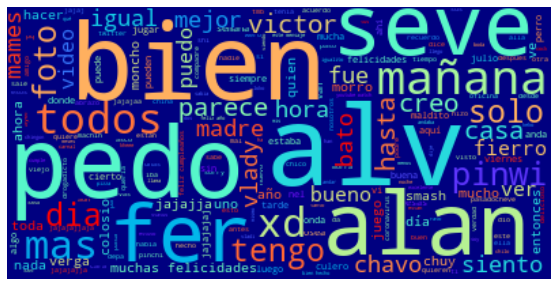

In [22]:
stopwords = set(STOPWORDS)
# REGREX = '[ja]?(ja)+[ja]?'
stopwords.update(["de", "la", "el", "lo", "la", "de", "que","del","si","esa","ese","al"
                      "es","en","pero","los","un","con","le", "porque", "como", "una"
                    , "para", "es","al", "las", "Multimedia", "omitido", "jajaja", "les", 
                  "todo", "ya", "jaja", "jajajaja", "te", "su", "ya", "jajajajaja", "se","yo","eso",
                  "cuando", "va", "ni", "son","pues","aqui","hoy","neta","por","simon","voy","ahi","asi",
                  "tu", "nos", "ok","mi","ok","jajajajajaja","era", "che", "ir", "más","vdd", "muy", "ala",
                  "jajajaj","hay","Jajaja","alguien","así","esta","eres","gracias", "tambien",
                  "aqui","está","hace","tiene","vez","nomas","ando","otro","https","estoy"
                 ])
wordcloud = WordCloud(stopwords=stopwords,background_color="navy",colormap='rainbow' ).generate(text)

plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [23]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

89


In [24]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])


emoji_dict = dict(Counter(total_emojis_list))

emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

print(emoji_dict)

[('🤣', 197), ('❤', 38), ('😂', 38), ('🏻', 34), ('🤔', 29), ('🏼', 29), ('😆', 27), ('👍', 26), ('💕', 17), ('👌', 17), ('👀', 16), ('💔', 15), ('😘', 13), ('🤤', 13), ('♂', 12), ('🤙', 12), ('🌚', 12), ('😱', 10), ('\U0001f974', 10), ('😬', 9), ('\U0001f92e', 8), ('😯', 8), ('🤷', 7), ('🍻', 7), ('😎', 7), ('💙', 6), ('🏿', 5), ('🤢', 5), ('🙌', 5), ('🤓', 5), ('✌', 4), ('😨', 4), ('\U0001f970', 4), ('\U0001f92d', 4), ('😞', 4), ('😍', 4), ('😅', 4), ('🙄', 3), ('☹', 3), ('\U0001f92a', 3), ('😉', 3), ('😔', 3), ('\U0001f928', 3), ('😁', 3), ('✨', 3), ('💖', 3), ('🤦', 3), ('☠', 2), ('😑', 2), ('📝', 2), ('😭', 2), ('😪', 2), ('👴', 2), ('😢', 2), ('💪', 2), ('🤗', 2), ('😏', 2), ('🕺', 2), ('👨', 2), ('🐧', 2), ('👏', 2), ('🐶', 2), ('🐙', 1), ('🙋', 1), ('🎤', 1), ('🎼', 1), ('🙆', 1), ('💅', 1), ('😊', 1), ('🙁', 1), ('🥂', 1), ('😖', 1), ('\U0001f973', 1), ('😰', 1), ('😒', 1), ('🤖', 1), ('✋', 1), ('\U0001f9a0', 1), ('\U0001f97a', 1), ('💩', 1), ('🐱', 1), ('\U0001f9b3', 1), ('😸', 1), ('🖖', 1), ('🏾', 1), ('🥗', 1), ('😕', 1), ('😓', 1), ('😛', 1)]

In [25]:
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,🤣,197
1,❤,38
2,😂,38
3,🏻,34
4,🤔,29
...,...,...
84,🏾,1
85,🥗,1
86,😕,1
87,😓,1


In [26]:
fig = px.pie(emoji_df, values ='count', names = 'emoji')
fig.update_traces(textposition = 'inside', textinfo = 'percent+label')
fig.show()

In [27]:
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Emoji Distribution for Fercho


Emoji Distribution for Cheve


Emoji Distribution for Monchis


Emoji Distribution for Toro


Emoji Distribution for Colo


Emoji Distribution for Weto


Emoji Distribution for Chewbacca


Emoji Distribution for Cuy


Emoji Distribution for Enano


In [28]:
fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=False
)
fig.show()

Number of messages as times move on

In [29]:
date_df = messages_df.groupby("Date").sum()

date_df.reset_index(inplace=True)

fig = px.line(date_df, x = "Date", y = "Word_Count")
fig.update_xaxes(nticks=20)
fig.show()

Dates with higher number of messages

Text(0, 0.5, 'Date')

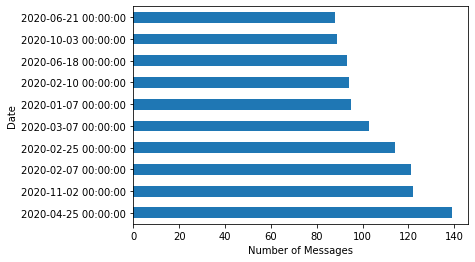

In [30]:
messages_df['Date'].value_counts().head(10).plot.barh()
plt.xlabel('Number of Messages')
plt.ylabel('Date')

In [31]:
fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0,3000] # adjust this for better resolution depending on how much the group is used
    )),
  showlegend=False
)

fig.show()

Text(0, 0.5, 'Time')

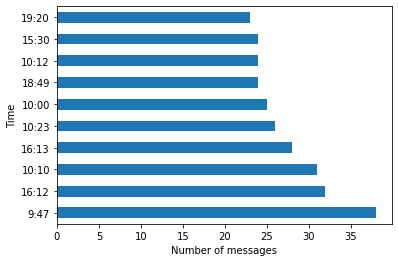

In [32]:
messages_df['Time'].value_counts().head(10).plot.barh() 

plt.xlabel('Number of messages')

plt.ylabel('Time')